## Configuration for Colab

In [36]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    !pip install "stable-baselines3[extra]>=2.0.0a4"
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import modules

# 07. Behavior Cloning (without HER)

[A. Nair et al., "Overcoming Exploration in Reinforcement Learning with Demonstrations." arXiv preprint arXiv:1709.10089, 2017.](https://arxiv.org/pdf/1709.10089.pdf)

Exploration in environments with sparse rewards has been a persistent problem in reinforcement learning. Many tasks are natural to  specify with a sparse reward, and manually shaping a reward function can result in suboptimal performance. However, finding a non-zero reward is exponentially more difficult with increasing task horizon or action dimensionality. In  this  paper, the authors use demonstrations to overcome the exploration problem and successfully learn to perform long-horizon, multi-step tasks with continuous control such as stacking blocks with a robot arm.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). Please see *03.DDPG.ipynb* for detailed description of DDPG.

### Demonstration Buffer
It maintains a second replay buffer $R_D$ where we store our the demonstration data in the same format as the original replay buffer $R$. In each minibatch, we draw extra $N_D$ examples from $R_D$ to use as off-policy replay data for the update step. These examples are included in both the actor and critic update.

### Behavior Cloning Loss
It computes only on the demonstration examples for training the actor.
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum} \lVert \pi (s_i | \theta_\pi) - a_i \rVert^2
$$
This loss is a standard loss in imitation learning, but this paper shows that using it as an auxiliary loss for RL improves learning significantly. The gradient applied to the actor parameters $\theta_\pi$ is:
$$
L_A = - \lambda_1 \nabla_{\theta_{\pi}}J + \lambda_2 \nabla_{\theta_{\pi}} L_{BC}
$$
Two parameters called  $\lambda_1$ ,  $\lambda_2$  are used to weight the contributions.

### Q-Filter
Using the above loss prevents the learned policy from improving significantly beyond the demonstration policy, as the actor is always tied back to the demonstrations. To avoid this problem, the authors apply the behavior cloning loss only to states where the critic $Q(s,a)$ determines that action of the demonstration is better than actor's action:
$$
L_{BC} = \underset{i=1}{\overset{N_D}\sum}\lVert \pi (s_i | \theta_\pi) - a_i \rVert^2 \mathbb{1}_{Q(s_i, a_i) > Q(s_i, \pi(s_i))}
$$


In [37]:
import os
import copy
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.vec_env import SubprocVecEnv

from IPython.display import clear_output


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Set random seed

In [38]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# By using the same seed, all these libraries will produce the same sequence of random numbers each time the code is run, ensuring consistent results across runs.
seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## OU Noise
*Ornstein-Uhlenbeck* process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference:
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [39]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self,
        size: int,
        mu: float = 0.0,
        theta: float = 0.15,
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

In [40]:
class TrajectorySegmenter:
    def __init__(self, n_agent, obs_dim, total_size, batch_size=32):
        self.n_agent = n_agent
        self.total_size = total_size
        segment_size = total_size // self.n_agent
        if segment_size == 0:
            raise ValueError("Number of segments is larger than the trajectory data size.")
        self.segment_size = segment_size

        self.obs_buf = np.zeros([n_agent, segment_size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([n_agent, segment_size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([n_agent, segment_size], dtype=np.float32)
        self.rews_buf = np.zeros([n_agent, segment_size], dtype=np.float32)
        self.done_buf = np.zeros([n_agent, segment_size], dtype=np.float32)

        self.batch_size = batch_size
        self.ptr, self.size, = 0, 0

    def segment(self, demo):
        for i in range(self.n_agent):
          start = i * self.segment_size
          end = (i + 1) * self.segment_size if i < self.n_agent - 1 else self.total_size
          demo_slice = demo[start: end+1]
          self.extend(i, demo_slice)

          self.extend(0, demo)

    def store(
        self,
        ageng_id: int,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[ageng_id][self.ptr] = obs
        self.next_obs_buf[ageng_id][self.ptr] = next_obs
        self.acts_buf[ageng_id][self.ptr] = act
        self.rews_buf[ageng_id][self.ptr] = rew
        self.done_buf[ageng_id][self.ptr] = done

        self.ptr = (self.ptr + 1) % self.segment_size
        self.size = min(self.size + 1, self.segment_size)

    def extend(
        self,
        ageng_id: int,
        trajectory: List[Tuple],
    ):
        """Store the trajectory in buffer."""
        for trajectory in trajectory:
            self.store(ageng_id, *trajectory)

    def sample_batch(self, ageng_id: int) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of data from segment."""
        segment_idxs = np.random.choice(self.segment_size, size=self.batch_size, replace=False)

        return dict(obs=self.obs_buf[ageng_id][segment_idxs],
                    next_obs=self.next_obs_buf[ageng_id][segment_idxs],
                    acts=self.acts_buf[ageng_id][segment_idxs],
                    rews=self.rews_buf[ageng_id][segment_idxs],
                    done=self.done_buf[ageng_id][segment_idxs])

    def __len__(self) -> int:
        return self.size


## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, *ReLU* for hidden layers and *tanh* for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers *ReLU*. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are *uniformly distributed.*

In [41]:
class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(
        self,
        in_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).
*segmentEnv* is an reset wrapper class to reset state to customized state.


In [42]:
class actionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

## Muti Agent
Here is a summary of Muti agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_plot              | plot the training progresses.                        |
|\_target_soft_update| soft update from the local model to the target model.|

In [43]:
class MutiAgent:
    """MutiAgent interacting with environment.

    Attribute:
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        demo (TrajectorySegmenter): demonstration data
        n_segments (int): num of segments
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        lambda1 (float): weight for policy gradient loss
        lambda2 (float): weight for behavior cloning loss
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env_id,
        memory_size: int,
        n_agent: int,
        batch_size: int,
        demo_batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        demo: list,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        # loss parameters
        lambda1: float = 1e-3,
        lambda2: int = 1.0
    ):

        env = gym.make(env_id)
        self.global_env = actionNormalizer(env)

        """Initialize."""
        obs_dim = self.global_env.observation_space.shape[0]
        action_dim = self.global_env.action_space.shape[0]

        self.n_agent = n_agent
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps

        # loss parameters
        self.lambda1 = lambda1
        self.lambda2 = lambda2 / demo_batch_size

        self.actor_losses = [[] for _ in range(n_agent)]
        self.critic_losses = [[] for _ in range(n_agent)]
        self.scores = [[] for _ in range(n_agent)]

        # demo segmentation
        self.demo_segmentation = TrajectorySegmenter(n_agent, obs_dim, len(demo), demo_batch_size)
        self.demo_segmentation.segment(demo)

        # initial state of each segment
        self.initial_states = [self.demo_segmentation.obs_buf[i][0] for i in range(n_agent)]

        self.local_env = [actionNormalizer(gym.make(env_id)) for i in range(n_agent)]

        # replay segmentation
        self.replay_segmentation = TrajectorySegmenter(n_agent, obs_dim, memory_size, batch_size)

        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = [torch.device("cuda" if torch.cuda.is_available() else "cpu") for _ in range(n_agent)]
        print(self.device)

        # global networks
        self.global_actor = Actor(obs_dim, action_dim).to(self.device[0])
        self.global_critic = Critic(obs_dim + action_dim).to(self.device[0])
        # local networks
        self.local_actor = [Actor(obs_dim, action_dim).to(self.device[i]) for i in range(n_agent)]
        self.local_critic = [Critic(obs_dim + action_dim).to(self.device[i]) for i in range(n_agent)]

        # # global networks
        # self.global_actor = Actor(obs_dim, action_dim).to(self.device)
        # self.global_critic = Critic(obs_dim + action_dim).to(self.device)
        # # local networks
        # self.local_actor = [Actor(obs_dim, action_dim).to(self.device) for i in range(n_agent)]
        # self.local_critic = [Critic(obs_dim + action_dim).to(self.device) for i in range(n_agent)]


        for i in range(n_agent):
            self.local_actor[i].load_state_dict(self.global_actor.state_dict())
            self.local_critic[i].load_state_dict(self.global_critic.state_dict())

        # optimizer
        for i in range(n_agent):
          self.local_actor_optimizer = [optim.Adam(self.local_actor[i].parameters(), lr=3e-4) for i in range(n_agent)]
          self.local_critic_optimizer = [optim.Adam(self.local_critic[i].parameters(), lr=1e-3) for i in range(n_agent)]

        # transition to store in memory
        self.transitions = [list() for _ in range(n_agent)]

        # total steps count
        self.total_step = 0

        # max test steps
        self.max_step = 5000

    def select_action(self, states: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        selected_actions = [0 for _ in range(self.n_agent)]
        for i in range(self.n_agent):
          if self.total_step < self.initial_random_steps:
              selected_actions[i] = self.local_env[i].action_space.sample()
          else:
              selected_actions[i] = self.local_actor[i](
                  torch.FloatTensor(states[i]).to(self.device[i])
              ).detach().cpu().numpy()

          # add noise for exploration during training
          noise = self.noise.sample()
          selected_actions[i] = np.clip(selected_actions[i] + noise, -1.0, 1.0)

          self.transitions[i] = [states[i], selected_actions[i]]

        return selected_actions

    def step(self, actions) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_states, rewards, dones = [[] for _ in range(self.n_agent)], [0 for _ in range(self.n_agent)], [0 for _ in range(self.n_agent)]
        for i in range(self.n_agent):
          next_states[i], rewards[i], dones[i], _ = self.local_env[i].step(actions[i])
          self.transitions[i] += [rewards[i], next_states[i], dones[i]]
          self.replay_segmentation.store(i, *self.transitions[i])

        return next_states, rewards, dones

    def update_model(self, agent_id) -> np.ndarray:
        """Update the model by gradient descent."""
        device = self.device[agent_id]

        # sample batch from replay segments
        samples = self.replay_segmentation.sample_batch(agent_id)
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # sample batch from demo segments
        d_samples = self.demo_segmentation.sample_batch(agent_id)
        d_state = torch.FloatTensor(d_samples["obs"]).to(device)
        d_next_state = torch.FloatTensor(d_samples["next_obs"]).to(device)
        d_action = torch.FloatTensor(d_samples["acts"].reshape(-1, 1)).to(device)
        d_reward = torch.FloatTensor(d_samples["rews"].reshape(-1, 1)).to(device)
        d_done = torch.FloatTensor(d_samples["done"].reshape(-1, 1)).to(device)

        masks = 1 - done
        next_action = self.global_actor(next_state)
        next_value = self.global_critic(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        curr_return = curr_return.to(device).detach()

        # train local critic
        values = self.local_critic[agent_id](state, action)
        local_critic_loss = F.mse_loss(values, curr_return)

        self.local_critic_optimizer[agent_id].zero_grad()
        local_critic_loss.backward()
        self.local_critic_optimizer[agent_id].step()

        # train local actor
        # PG loss
        pg_loss = -self.local_critic[agent_id](state, self.local_actor[agent_id](state)).mean()

        # BC loss with Q filter
        pred_action = self.local_actor[agent_id](d_state)
        qf_mask = torch.gt(
            self.local_critic[agent_id](d_state, d_action),
            self.local_critic[agent_id](d_state, pred_action),
        ).to(device)
        qf_mask = qf_mask.float()
        n_qf_mask = int(qf_mask.sum().item())

        if n_qf_mask == 0:
            bc_loss = torch.zeros(1, device=device)
        else:
            bc_loss = (
                torch.mul(pred_action, qf_mask) - torch.mul(d_action, qf_mask)
            ).pow(2).sum() / n_qf_mask

        local_actor_loss = self.lambda1 * pg_loss + self.lambda2 * bc_loss

        self.local_actor_optimizer[agent_id].zero_grad()
        local_actor_loss.backward()
        self.local_actor_optimizer[agent_id].step()

        self.global_soft_update(agent_id)

        return local_actor_loss.data.detach().cpu().numpy(), local_critic_loss.data.detach().cpu().numpy()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        states = [[] for _ in range(self.n_agent)]
        for i in range(self.n_agent):
          states[i] = self.local_env[i].reset(options={'theta': np.arccos(self.initial_states[i][0]), 'theta_dot': self.initial_states[i][2]}, seed=0)
          # states[i] = self.local_env[i].reset(seed=0)

        score = [0 for _ in range(self.n_agent)]

        for self.total_step in range(1, num_frames + 1):
            actions = self.select_action(states)
            next_states, rewards, dones = self.step(actions)
            states = next_states

            for i in range(self.n_agent):
              score[i] += rewards[i]
              # if episode ends
              if dones[i]:
                states[i] = self.local_env[i].reset(seed=0)
                self.scores[i].append(score[i])
                score[i] = 0

              # if training is ready
              # if len(self.replay_segmentation) >= self.batch_size and self.total_step > self.initial_random_steps:
              if self.total_step > self.initial_random_steps:
                  actor_loss, critic_loss = self.update_model(i)
                  self.actor_losses[i].append(actor_loss)
                  self.critic_losses[i].append(critic_loss)

            # plotting
            if self.total_step % plotting_interval == 0:
                self.plot_train()

        for i in range(self.n_agent):
          self.local_env[i].close()

    def test(self):
        """Test the global agent."""
        device = self.device[0]
        state = self.global_env.reset(seed=0)
        done = False
        score = 0
        test_step = 0

        while not done or self.max_step > test_step:
            action = self.global_actor(
                torch.FloatTensor(state).to(device)).detach().cpu().numpy()

            next_state, reward, done, _ = self.global_env.step(action)

            state = next_state
            score += reward
            test_step += 1

        print("score: ", score)
        self.global_env.close()

    def global_soft_update(self, agent_id):
        """Soft-update: global = tau*local + (1-tau)*global."""
        tau = self.tau

        for g_param, l_param in zip(
            self.global_actor.parameters(), self.local_actor[agent_id].parameters()
        ):
            g_param.data.copy_(tau * l_param.data + (1.0 - tau) * g_param.data)

        for g_param, l_param in zip(
            self.global_critic.parameters(), self.local_critic[agent_id].parameters()
        ):
            g_param.data.copy_(tau * l_param.data + (1.0 - tau) * g_param.data)

    def plot_train(self):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)
            # adjust the spacing between subplots
            plt.subplots_adjust(hspace=0.2)

        # loop over the agents
        subplot_params = []
        for i in range(self.n_agent):
            # calculate the subplot location based on the row and column index
            loc = 100*self.n_agent + 30 + 3*i

            # plot the score, actor_loss and critic_loss for each agent
            subplot_params.extend([(loc+1, f"frame {self.total_step}. score: {np.mean(self.scores[i][-10:])}", self.scores[i]),
            (loc + 2, "actor_loss", self.actor_losses[i]),
            (loc + 3, "critic_loss", self.critic_losses[i])])

        clear_output(True)
        # create a figure with self.n_agent rows and 3 columns of subplots
        plt.figure(figsize=(20, 5*self.n_agent))
        for loc, title, values in subplot_params:
          subplot(loc, title, values)
        plt.show()

## Initialize
We make the demonstration using the well-trained agent in advance. (The given demo.pkl is created using *03.DDPG* agent.)

In [44]:
import pickle

# load demo on replay memory
demo_path = "demo.pkl"
with open(demo_path, "rb") as f:
    demo = pickle.load(f)

In [45]:
# parameters
n_agent = 2
num_frames = 30000
memory_size = 100000
batch_size = 128
demo_batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

env_id = "Pendulum-v1"

agent = MutiAgent(
    env_id,
    memory_size,
    n_agent,
    batch_size,
    demo_batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    demo,
    initial_random_steps=initial_random_steps,
)

[device(type='cuda'), device(type='cuda')]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Train

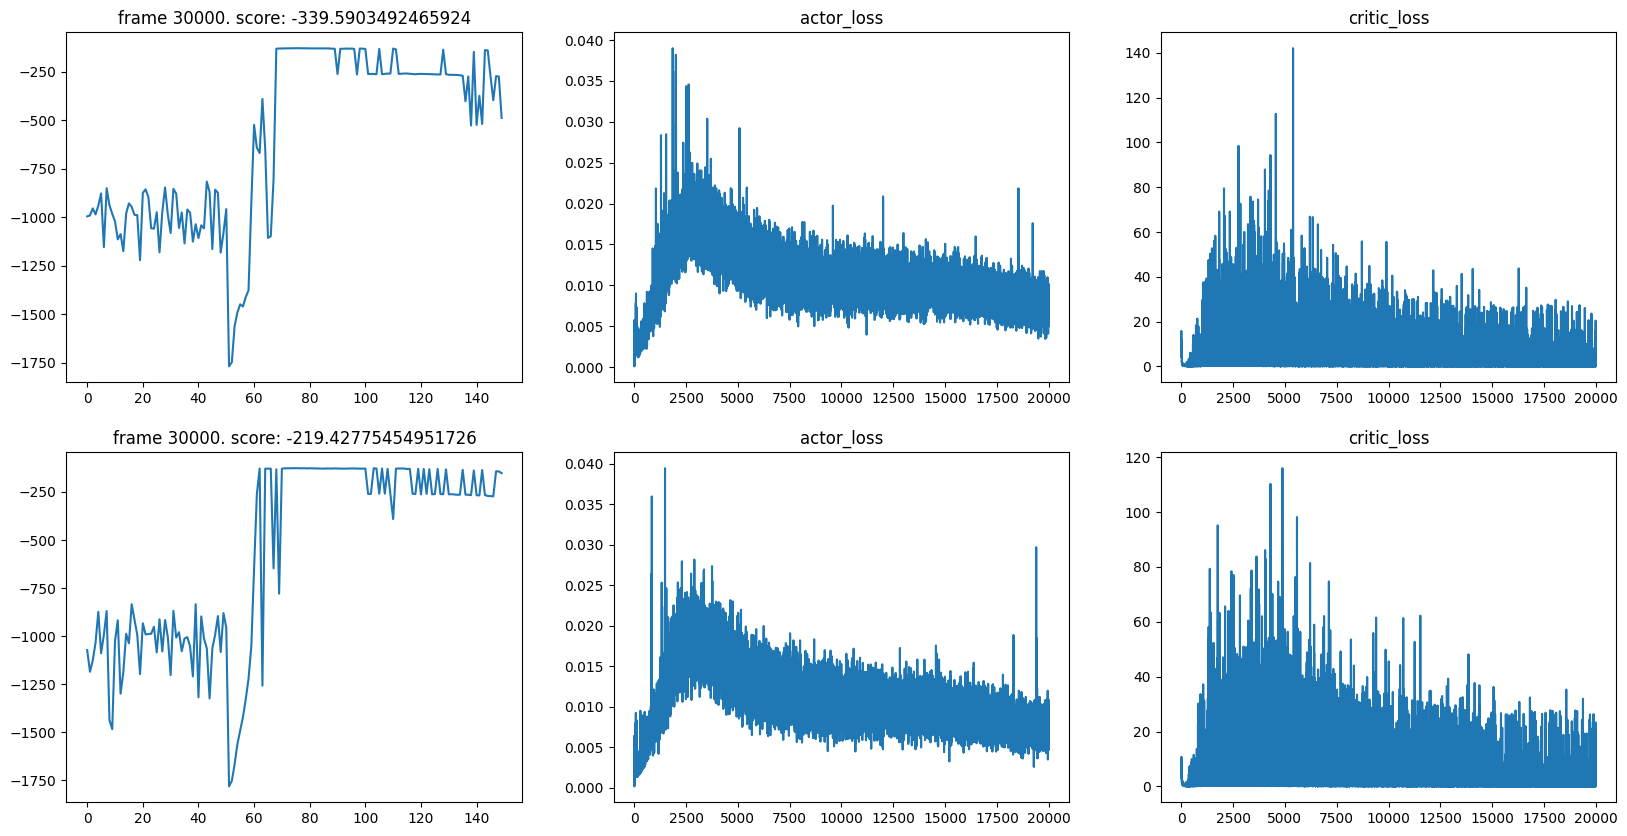

In [46]:
# processes = []
# for i in range(n_agent):
#     # environment
#     env_id = "Pendulum-v1"
#     env = gym.make(env_id, new_step_api=True)
#     env = ActionNormalizer(env, new_step_api=True)
#     p = mp.Process(target = agent.train, args = (i, env, num_frames))
#     p.start()
#     processes.append(p)

# for p in processes:
#     p.join()


# from stable_baselines.common import set_global_seeds
# from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv

# set_global_seeds(seed)

agent.train(num_frames)





In [47]:
agent.test()

score:  -6708.689232052821
